In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1. Load Data

In [2]:
from urllib.request import HTTPError

def load_turnstile_data(urls):
    dfs = []
    for url in urls:
        try:
            df = pd.read_csv(url)
            dfs.append(df)
        except HTTPError as err:
            if err.code == 404:
                continue
            else:
                raise err
    return pd.concat(dfs).reset_index()

def format_day_month(num):
    return '0' + str(num) if num < 10 else str(num)

def format_year(num):
    return str(num)[-2:]

def generate_url(date):
    y = format_year(date.year)
    m = format_day_month(date.month)
    d = format_day_month(date.day)
    return f'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{y}{m}{d}.txt'

In [3]:
def fetch_data_for_week_range(start, end):
    assert pd.to_datetime(start).weekday() == 5, "Start must be a Saturday to match turnstile data"
    assert pd.to_datetime(start).weekday() == 5, "End must be a Saturday to match turnstile data"
    
    urls = list(map(generate_url, pd.date_range(start, end, freq="7D")))
    return load_turnstile_data(urls)

In [4]:
mta_data = fetch_data_for_week_range('3/2/2019', '3/30/2019')

In [5]:
with open('mta_data_march.pickle', 'wb') as write_file:
    pickle.dump(mta_data, write_file)

In [6]:
mta_data.shape

(1016285, 12)

In [7]:
orig_num_rows = mta_data.shape[0]

# 2. Clean Data

In [8]:
with open('mta_data_march.pickle', 'rb') as read_file:
    mta_data = pickle.load(read_file).reset_index()

In [9]:
mta_data.columns

Index(['level_0', 'index', 'C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME',
       'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [10]:
mta_data.columns = [col.strip() for col in mta_data.columns]

In [11]:
mta_data = mta_data.sort_values(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME'])

## 2.0 Check For Duplicates

### 2.0.1 How many duplicates are there?

In [12]:
by_unique_count = mta_data.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME']).agg({ 'ENTRIES': 'count'}).reset_index()

In [13]:
# There are 57 duplicate entries
by_unique_count[by_unique_count.ENTRIES > 1].shape

(57, 7)

### 2.0.2 Duplicates Exploration

In [14]:
# QQ: I considered putting a summary of what was discovered at the top rather than the bottom but wasn't sure.
# What's best practice

In [15]:
mta_data['num_dups'] = mta_data.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME'])['ENTRIES'].transform('count')

In [16]:
with_dups = mta_data[mta_data.num_dups > 1].sort_values(['C/A', 'UNIT', 'SCP', 'STATION', 'num_dups'])

In [17]:
with_dups.shape

(114, 14)

In [18]:
with_dups.describe()

,level_0,index,ENTRIES,EXITS,num_dups
count,114.000,114.000,114.000,114.000,114.000
mean,452651.798,75263.798,7068988.395,7762899.395,2.000
std,409794.858,38036.586,6172817.503,6717998.744,0.000
min,53585.000,5067.000,2471.000,0.000,2.000
25%,53752.250,53694.250,2114976.000,1451309.750,2.000
50%,146109.500,53902.500,5870442.000,7068961.500,2.000
75%,911929.750,100251.750,9699393.750,10685032.750,2.000
max,911959.000,146153.000,18100105.000,18839460.000,2.000


In [19]:
with_dups.DESC.unique()

array(['REGULAR', 'RECOVR AUD'], dtype=object)

In [20]:
with_dups.groupby(['DESC']).agg('count')

,level_0,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,num_dups
DESC,,,,,,,,,,,,,
RECOVR AUD,57,57,57,57,57,57,57,57,57,57,57,57,57
REGULAR,57,57,57,57,57,57,57,57,57,57,57,57,57


In [21]:
across_desc = pd.pivot_table(with_dups,
               values='ENTRIES',
               columns='DESC',
               index=['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME'],
               aggfunc='mean')


In [22]:
across_desc['dup_diff'] = across_desc['RECOVR AUD'] - across_desc['REGULAR']

In [23]:
across_desc['dup_diff'].describe()

count          57.000
mean     -4023566.404
std       6243779.993
min     -10314855.000
25%     -10314674.000
50%      -5383636.000
75%        131439.000
max      16148594.000
Name: dup_diff, dtype: float64

In [24]:
mta_data['prev_entries'] = mta_data.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['ENTRIES'].transform(lambda grp: grp.shift(1))
mta_data['prev_desc'] = mta_data.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['DESC'].transform(lambda grp: grp.shift(1))


In [25]:
mta_data['next_entries'] = mta_data.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['ENTRIES'].transform(lambda grp: grp.shift(-1))
mta_data['next_desc'] = mta_data.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['DESC'].transform(lambda grp: grp.shift(-1))



In [26]:
across_desc = across_desc.reset_index()

In [27]:
across_desc = across_desc.merge(
    mta_data[['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME', 'DESC', 'prev_entries', 'prev_desc', 'next_entries', 'next_desc']],
    how='inner',
    on=['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME']
)

In [28]:
across_desc[across_desc['dup_diff'] > 100].shape

(34, 14)

In [29]:
across_desc[across_desc['dup_diff'] > 100].head(34)

,C/A,UNIT,SCP,STATION,DATE,TIME,RECOVR AUD,REGULAR,dup_diff,DESC,prev_entries,prev_desc,next_entries,next_desc
12,N071,R013,00-00-00,34 ST-PENN STA,02/27/2019,19:00:00,5870225,2196639,3673586,REGULAR,5869852.000,REGULAR,5870225.000,RECOVR AUD
13,N071,R013,00-00-00,34 ST-PENN STA,02/27/2019,19:00:00,5870225,2196639,3673586,RECOVR AUD,2196639.000,REGULAR,2196693.000,REGULAR
14,N071,R013,00-00-00,34 ST-PENN STA,02/27/2019,23:00:00,5870426,2196693,3673733,REGULAR,5870225.000,RECOVR AUD,5870426.000,RECOVR AUD
15,N071,R013,00-00-00,34 ST-PENN STA,02/27/2019,23:00:00,5870426,2196693,3673733,RECOVR AUD,2196693.000,REGULAR,2196699.000,REGULAR
16,N071,R013,00-00-00,34 ST-PENN STA,02/28/2019,03:00:00,5870458,2196699,3673759,REGULAR,5870426.000,RECOVR AUD,5870458.000,RECOVR AUD
17,N071,R013,00-00-00,34 ST-PENN STA,02/28/2019,03:00:00,5870458,2196699,3673759,RECOVR AUD,2196699.000,REGULAR,2196731.000,REGULAR
18,N071,R013,00-00-00,34 ST-PENN STA,02/28/2019,07:00:00,5870469,2196732,3673737,REGULAR,2196731.000,REGULAR,5870469.000,RECOVR AUD
19,N071,R013,00-00-00,34 ST-PENN STA,02/28/2019,07:00:00,5870469,2196732,3673737,RECOVR AUD,2196732.000,REGULAR,5870625.000,REGULAR
20,N071,R013,00-00-01,34 ST-PENN STA,02/27/2019,19:00:00,3172052,2224501,947551,REGULAR,3171790.000,REGULAR,3172052.000,RECOVR AUD
21,N071,R013,00-00-01,34 ST-PENN STA,02/27/2019,19:00:00,3172052,2224501,947551,RECOVR AUD,2224501.000,REGULAR,2224575.000,REGULAR


#### Possible Remedies

There are only 34 duplicates with meaningfully different values which we can visually inspect in their entirety. With the exception of HOUSTON ST, the "RECOVR AUD" is the correct value based on which value more closely matches the preceeding value and the post-ceeding value.

Option 1: Clean this specific data
1. Remove Houston ST REGULAR record individually
2. Remove all other duplicates, choosing the RECOVR AUD

However, this would couple the cleaning notebook to this specific dataset

Option 2: Assume RECOVR AUD is always more accurate
1. Remove all duplicates, choosing the RECOVR AUD

It's unclear if this assumption would hold with other datasets

Option 3: Remove any record that has a duplicate (assume it will usually be a small number)
1. Remove all records with a duplicate

#### Choice: Option 2. Semantically, it seems plausible that a "recovery" reading would be the correct one


### 2.0.3 Remove Duplicates

In [30]:
def remove_duplicates(raw):
    raw_sorted = raw.sort_values(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME', 'DESC'])
    return raw_sorted.drop_duplicates(subset=['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME'], keep='first')

In [31]:
no_dups = remove_duplicates(mta_data)

In [32]:
# validate
no_dups.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME'])\
    .agg({ 'ENTRIES': 'count'})\
    .reset_index()\
    .ENTRIES.unique()

array([1])

------ _CHECKPOINT_ ------

In [33]:
# QQ: How often should you check point?
with open('../src/data/mta_data_march_no_duplicates.pickle', 'wb') as write_file:
    pickle.dump(no_dups, write_file)

In [34]:
with open('../src/data/mta_data_march_no_duplicates.pickle', 'rb') as read_file:
    no_dups = pickle.load(read_file)

------ _CHECKPOINT_ ------

## 2.1 Subset Data

In [35]:
# QQ: Is this a good thing to do?
subset = no_dups[['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME', 'ENTRIES']].copy()

## 2.2 Convert Date Formatting

In [36]:
def convert_date_formats(raw):
    raw['datetime'] = pd.to_datetime(raw.DATE + ' ' + raw.TIME)
    raw['DATE'] = pd.to_datetime(raw.DATE)
    raw['TIME'] = pd.to_datetime(raw.TIME).dt.time
    return raw

In [37]:
with_formatted_dates = convert_date_formats(subset)

## 2.3 Calculate Entries for Each Time Interval

In [38]:
def add_interval_data(raw):
    sorted_data = raw.sort_values(['C/A', 'UNIT', 'SCP', 'STATION', 'datetime'])
    sorted_data['entries_since_last_record'] = sorted_data.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['ENTRIES'].diff(1)
    sorted_data['time_interval'] = sorted_data.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['datetime'].diff(1)
    return sorted_data

In [39]:
with_interval_data = add_interval_data(with_formatted_dates)

## 2.4 Handle Outliers

### 2.4.1 Visualize Outliers

In [40]:
intervals_in_hours = with_interval_data.time_interval.dt.total_seconds() / 3600

Text(0.5, 1.0, 'Raw')

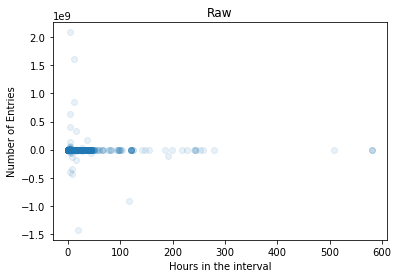

In [41]:
plt.scatter(intervals_in_hours, with_interval_data.entries_since_last_record, alpha=0.1)
plt.xlabel('Hours in the interval')
plt.ylabel('Number of Entries')
plt.title('Raw')

(-3000, 5000)

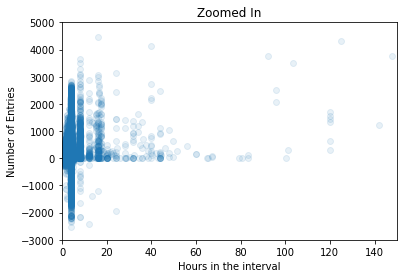

In [42]:
plt.scatter(intervals_in_hours, with_interval_data.entries_since_last_record, alpha=0.1)
plt.xlabel('Hours in the interval')
plt.ylabel('Number of Entries')
plt.title('Zoomed In')
plt.xlim([0,150])
plt.ylim([-3000, 5000])

#### Conclusion:

There does not appear to be a strong relationship between long intervals and high entry values. Therefore, we assume that high entry values and large time intervals are erroneous outliers.

### 2.4.2 Remove Outliers Within A Turnstile

#### Discussion

Our anlysis is primarily focused on the most trafficed stations. Therefore, we need to be careful removing large outliers. If those presumed outliers are in fact correct, then we are losing our most relevant data.

Instead, we will focus on removing outliers _within_ a single turnstile. It is much less likely a single turnstile gets an accurate reading that significantly deviates from the mean. That way we avoid simply removing the most popular turnstiles that are consistently the most popular.

In [43]:
def add_turnstile_deviations(raw):
    raw['unit_mean'] = raw.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['entries_since_last_record'].transform('mean')
    raw['unit_std'] = raw.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['entries_since_last_record'].transform('std')
    raw['deviations'] = (raw['entries_since_last_record'] - raw['unit_mean']) / raw['unit_std']
    
    return raw

In [44]:
with_deviations = add_turnstile_deviations(with_interval_data)

In [45]:
with_deviations.describe([0.0001, 0.001, 0.01, 0.1, 0.9, 0.99, 0.999, 0.9999])

,ENTRIES,entries_since_last_record,time_interval,unit_mean,unit_std,deviations
count,1016228.000,1011345.000,1011345,1016214.000,1016208.000,960165.000
mean,40531720.477,2066.164,0 days 03:59:40.352342,2065.031,149970.390,0.000
std,208316979.532,3421290.183,0 days 01:36:08.495436,234277.083,3418352.893,0.998
min,0.000,-1428035580.000,0 days 00:00:01,-7069372.589,0.000,-14.933
0.01%,0.000,-165489.109,0 days 00:00:34,-7069372.589,0.000,-13.711
0.1%,0.000,-801.000,0 days 00:01:20,-642517.976,0.000,-1.746
1%,0.000,0.000,0 days 01:21:40,-9349.700,0.000,-1.351
10%,18386.000,0.000,0 days 04:00:00,0.048,0.951,-0.991
50%,2285611.500,68.000,0 days 04:00:00,137.986,143.202,-0.186
90%,15415554.900,479.000,0 days 04:00:00,364.577,380.190,1.428


#### Conclusion

Chose a cutoff of 5 standard deviations. We consider that to be a very conservative threshold. 99.9% of the data falls below that value so we don't risk removing the highest readings which are most valuable.

In [46]:
def remove_intra_turnstile_outliers(raw, dev_threshold):
    return raw[((raw.deviations > -dev_threshold) & (raw.deviations < dev_threshold)) | raw.deviations.isna()]

In [47]:
no_turnstile_outliers = remove_intra_turnstile_outliers(with_deviations, dev_threshold=5)

In [48]:
# validate
perc_removed_so_far = 1 - (no_turnstile_outliers.shape[0] / mta_data.shape[0])
print(f"So far, we've removed {perc_removed_so_far * 100} percent of the data")

So far, we've removed 0.09515047452239855 percent of the data


### 2.4.3 Visualize Remaining Outliers

In [49]:
new_interval_in_hours = no_turnstile_outliers.time_interval.dt.total_seconds() / 3600

Text(0.5, 1.0, 'Raw')

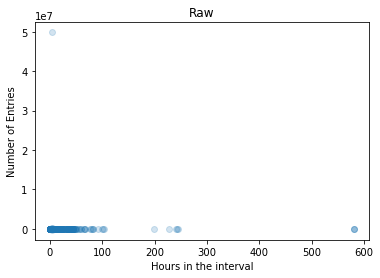

In [50]:
plt.scatter(new_interval_in_hours, no_turnstile_outliers.entries_since_last_record, alpha=0.2)
plt.xlabel('Hours in the interval')
plt.ylabel('Number of Entries')
plt.title('Raw')


(-3000, 5000)

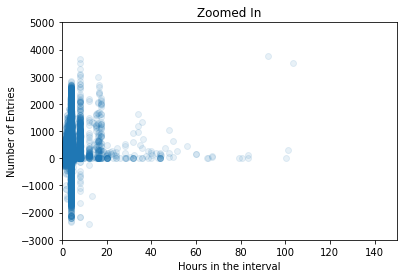

In [51]:
plt.scatter(new_interval_in_hours, no_turnstile_outliers.entries_since_last_record, alpha=0.1)
plt.xlabel('Hours in the interval')
plt.ylabel('Number of Entries')
plt.title('Zoomed In')
plt.xlim([0,150])
plt.ylim([-3000, 5000])

In [52]:
no_turnstile_outliers.describe([0.0001, 0.001, 0.005, 0.01, 0.1, 0.9, 0.99, 0.999, 0.9999])

,ENTRIES,entries_since_last_record,time_interval,unit_mean,unit_std,deviations
count,1015318.000,1010435.000,1010435,1015304.000,1015298.000,959255.000
mean,40538017.615,217.014,0 days 03:59:15.262572,2059.017,149284.215,-0.004
std,208330564.511,49617.448,0 days 01:16:05.059731,233814.760,3411244.438,0.955
min,0.000,-287462.000,0 days 00:00:01,-7069372.589,0.000,-4.948
0.01%,0.000,-1595.870,0 days 00:00:34,-7069372.589,0.000,-2.750
0.1%,0.000,-719.566,0 days 00:01:20,-642517.976,0.000,-1.656
0.5%,0.000,-145.000,0 days 00:10:36,-39896.757,0.000,-1.414
1%,0.000,0.000,0 days 01:21:46,-9349.700,0.000,-1.349
10%,18645.700,0.000,0 days 04:00:00,0.048,0.968,-0.991
50%,2290781.000,68.000,0 days 04:00:00,138.129,143.222,-0.187


#### Conclusion

For both `entries_since_last_record` and `time_interval`, there is a massive gap between the 99.99% percentile and the maximum. That is also true of the gap between the 0.01% percentile and the minimum for `entries_since_last_record`.

We want to choose a threshold between those values.

Also, any interval less than a minute is almost certainly not relevant. Either the reading is accurate and it adds a negligible number of entrants or it's an error. Therefore, we should remove those low intervals.

### 2.4.3 Remove Extreme Outliers

In [53]:
def remove_extreme_entries(mta):   
     return mta[
         (mta.entries_since_last_record < mta.entries_since_last_record.quantile(0.99995)) &
         (mta.entries_since_last_record > mta.entries_since_last_record.quantile(1 - 0.99995))
     ]

In [54]:
def remove_extreme_intervals(mta):   
     return mta[
         (mta.time_interval < mta.time_interval.quantile(0.99995)) & 
         (mta.time_interval > mta.time_interval.quantile(0.01))
     ]

In [55]:
no_extremes = remove_extreme_intervals(remove_extreme_entries(no_turnstile_outliers))

Text(0.5, 1.0, 'With No Extreme Outliers')

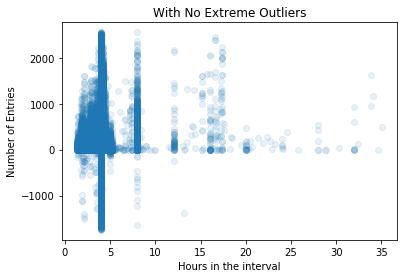

In [56]:
interval_in_hours = no_extremes.time_interval.dt.total_seconds() / 3600

plt.scatter(interval_in_hours, no_extremes.entries_since_last_record, alpha=0.1)
plt.xlabel('Hours in the interval')
plt.ylabel('Number of Entries')
plt.title('With No Extreme Outliers')

In [57]:
perc_removed = 1 - (no_extremes.shape[0] / mta_data.shape[0])
print(f'So far we have removed {np.round(perc_removed * 100, 2)} percent of the data')

So far we have removed 1.58 percent of the data


In [58]:
no_extremes.head()

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES,datetime,entries_since_last_record,time_interval,unit_mean,unit_std,deviations
1,A002,R051,02-00-00,59 ST,2019-02-23,07:00:00,6955494,2019-02-23 07:00:00,11.000,04:00:00,202.453,225.514,-0.849
2,A002,R051,02-00-00,59 ST,2019-02-23,11:00:00,6955554,2019-02-23 11:00:00,60.000,04:00:00,202.453,225.514,-0.632
3,A002,R051,02-00-00,59 ST,2019-02-23,15:00:00,6955714,2019-02-23 15:00:00,160.000,04:00:00,202.453,225.514,-0.188
4,A002,R051,02-00-00,59 ST,2019-02-23,19:00:00,6956004,2019-02-23 19:00:00,290.000,04:00:00,202.453,225.514,0.388
5,A002,R051,02-00-00,59 ST,2019-02-23,23:00:00,6956147,2019-02-23 23:00:00,143.000,04:00:00,202.453,225.514,-0.264


In [59]:
no_extremes = no_extremes.drop(columns=['deviations', 'unit_mean', 'unit_std'])

------ _CHECKPOINT_ ------

In [60]:
# QQ: How often should you check point?
with open('../src/data/mta_data_march_no_extremes.pickle', 'wb') as write_file:
    pickle.dump(no_extremes, write_file)

In [61]:
with open('../src/data/mta_data_march_no_extremes.pickle', 'rb') as read_file:
    no_extremes = pickle.load(read_file).reset_index()

------ _CHECKPOINT_ ------

## 2.5 Investigate Negatives

### 2.5.1 How Many

In [62]:
no_extremes[no_extremes.entries_since_last_record < 0].shape[0] / no_extremes.shape[0]

0.008853424090511888

In [63]:
no_extremes.head()

,index,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES,datetime,entries_since_last_record,time_interval
0,1,A002,R051,02-00-00,59 ST,2019-02-23,07:00:00,6955494,2019-02-23 07:00:00,11.000,04:00:00
1,2,A002,R051,02-00-00,59 ST,2019-02-23,11:00:00,6955554,2019-02-23 11:00:00,60.000,04:00:00
2,3,A002,R051,02-00-00,59 ST,2019-02-23,15:00:00,6955714,2019-02-23 15:00:00,160.000,04:00:00
3,4,A002,R051,02-00-00,59 ST,2019-02-23,19:00:00,6956004,2019-02-23 19:00:00,290.000,04:00:00
4,5,A002,R051,02-00-00,59 ST,2019-02-23,23:00:00,6956147,2019-02-23 23:00:00,143.000,04:00:00


#### Conclusion

In a real world setting, we would simply drop the <1% of data points that are negative. But in order to practice, we kept investigating.

### 2.5.2 Consistently Negative Turnstiles

#### Observation

A number of the turnstiles appear to _consistently_ have negative values.

In [64]:
no_extremes['always_decreasing'] = no_extremes.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['ENTRIES'].transform(lambda s: s.is_monotonic_decreasing)


In [65]:
always_decreasing = no_extremes[
    (no_extremes.entries_since_last_record < 0) & # has negative entries for a time period
    no_extremes.always_decreasing # the turnstile the record is from *always* has negative entries
]

In [66]:
always_decreasing.describe([0.0001, 0.001, 0.01, 0.1, 0.9, 0.99, 0.999, 0.9999])

,index,ENTRIES,entries_since_last_record,time_interval
count,8674.000,8674.000,8674.000,8674
mean,506952.023,1204155153.260,-303.026,0 days 04:00:02.784874
std,292775.962,654032517.828,332.654,0 days 00:13:38.890486
min,3605.000,8695.000,-1750.000,0 days 01:26:07
0.01%,3605.867,8978.607,-1743.929,0 days 01:26:57.303400
0.1%,3613.673,10625.798,-1715.981,0 days 01:50:30
1%,11678.730,25290.900,-1497.540,0 days 04:00:00
10%,89342.100,98310048.000,-752.700,0 days 04:00:00
50%,496057.500,1291169417.500,-194.000,0 days 04:00:00
90%,901384.700,1942992490.000,-15.000,0 days 04:00:00


Text(0.5, 1.0, 'Raw')

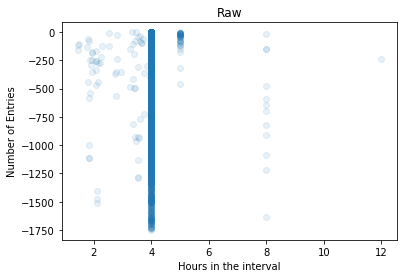

In [67]:
interval_in_hours = always_decreasing.time_interval.dt.total_seconds() / 3600

plt.scatter(interval_in_hours, always_decreasing.entries_since_last_record, alpha=0.1)
plt.xlabel('Hours in the interval')
plt.ylabel('Number of Entries')
plt.title('Raw')

In [68]:
perc_of_neg_on_always_decr_turnstiles = always_decreasing.shape[0] / no_extremes[no_extremes.entries_since_last_record < 0].shape[0]
print(f'{perc_of_neg_on_always_decr_turnstiles * 100} of the negative values in the data are on turnstiles that alway have negative readings')

97.95595708639186 of the negative values in the data are on turnstiles that alway have negative readings


#### Conclusion

The vast majority of the negative values in the data set are on turnstiles that consistently and uniformly have their counters going down. In addition, their absolute values are reasonable and fall within the range of positive values observed in the data. Finally, the vast majority of the records have the expected 4 hour interval.

Therefore, we assume these readings are accurate with simply a flipped sign. 

### 2.5.3 Flip Reasonable Negatives

In [69]:
def flip_reasonable_negative_entries_since_last_interval(mta):
    """Finds all "reasonable" negative values for `entries_since_last_interval` and corrects them to be positive.

    A record is considered to be a "reasonable" negative if it meets the following criteria:
        - it is on a turnstile which exclusively has decreasing entrance readings
        - it is NOT in the lowest 1% of negative readings
        - it has an interval of 4hours

    Args:
        param1 (dataframe): the MTA data

    Returns:
        dataframe: the corrected dataframe
    """
    
    # QQ: Seems very side effect-y. Is it worth it to copy the df first?
    mta['entries_since_last_record'] = np.where(
        (
            (mta.entries_since_last_record < 0) &
            mta.always_decreasing &
            (mta.entries_since_last_record > mta[mta.entries_since_last_record < 0].entries_since_last_record.quantile(0.01)) &
            (mta.time_interval == pd.Timedelta('4 hours'))
        ),
        np.abs(no_extremes.entries_since_last_record),
        no_extremes.entries_since_last_record
    )
    return mta

In [70]:
flipped_negatives = flip_reasonable_negative_entries_since_last_interval(no_extremes)

### 2.5.4 Drop Remaining Negatives

In [71]:
def drop_negatives(mta):
    return mta[mta.entries_since_last_record >= 0]

In [72]:
no_negatives = drop_negatives(flipped_negatives)

### 2.5.5 Validate

In [73]:
f'So far we have removed {np.round(100-(no_negatives.shape[0] / mta_data.shape[0] * 100), 2)} percent of the data'

'So far we have removed 1.62 percent of the data'

Text(0.5, 1.0, 'Without Negatives')

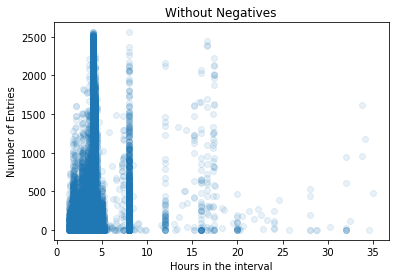

In [74]:
plt.scatter(no_negatives.time_interval.dt.total_seconds() / 3600, no_negatives.entries_since_last_record, alpha=0.1)
plt.xlabel('Hours in the interval')
plt.ylabel('Number of Entries')
plt.title('Without Negatives')

In [75]:
no_negatives = no_negatives.drop(columns=['always_decreasing'])

In [100]:
no_negatives.shape[0] / orig_num_rows

0.9837673487259971

------ _CHECKPOINT_ ------

In [76]:
# QQ: How often should you check point?
with open('../src/data/mta_data_march_no_negatives.pickle', 'wb') as write_file:
    pickle.dump(no_negatives, write_file)

In [77]:
with open('../src/data/mta_data_march_no_negatives.pickle', 'rb') as read_file:
    no_negatives = pickle.load(read_file)

------ _CHECKPOINT_ ------

## 2.6 Intervals That Cross Days

### 2.6.1 How many readings overlap a day?

In [78]:
more_than_one_day = no_negatives[no_negatives.datetime.dt.hour < (no_negatives.time_interval.dt.total_seconds() / 3600)]

f'{np.round(more_than_one_day.shape[0] / no_negatives.shape[0] * 100, 2)} percent of records overlap days'

'16.6 percent of records overlap days'

In [79]:
import datetime

and_at_midnight = more_than_one_day[more_than_one_day.TIME == datetime.time(0, 0)]
f'Of those, {np.round(and_at_midnight.shape[0] / more_than_one_day.shape[0] * 100, 2)} percent are readings at midnight'

'Of those, 44.53 percent are readings at midnight'

In [80]:
num_over_24_hours = more_than_one_day[more_than_one_day.time_interval.dt.total_seconds() >= (24 * 3600)].shape[0]

f'And {np.round(num_over_24_hours / more_than_one_day.shape[0] * 100, 2)} percent are over 24 hours'

'And 0.02 percent are over 24 hours'

#### Conclusion:

The majority of the records are readings at midnight. We can simply adjust their time reading to 23:59 the previous day to ensure the record falls on the date in which people entered. The information of the DATE and TIME fields are redundant and we can drop those fields in favor of the `datetime` column.

Less than 2% of the records that span more than one day cover more than 24 hours. Considering that represents less than 0.001% of the entire data set, we will simply remove those records.

With the rest, we will proportionally distribute the entrants based on how many hours the interval was in each day. This will allow us to aggregate more accurate daily readings.

### 2.6.2 Prepare Date Fields

In [81]:
def remove_intervals_gt_day(mta):
    return mta[mta.time_interval < pd.Timedelta('24 hours')].copy()

In [82]:
def add_start_end_columns(mta):
    mta['start_datetime'] = mta.datetime - mta.time_interval
    return mta.rename(columns={ 'datetime': 'end_datetime'})

In [83]:
no_gt_24 = remove_intervals_gt_day(no_negatives)
no_gt_24 = add_start_end_columns(no_gt_24).drop(columns=['DATE', 'TIME'])

In [84]:
def move_midnight_to_day_before(mta):
    mta['end_datetime'] = np.where(
        mta.end_datetime.dt.hour == 0,
        mta.end_datetime - pd.Timedelta('1 second'),
        mta.end_datetime
    )
    return mta

In [85]:
no_midnight = move_midnight_to_day_before(no_gt_24)

### 2.6.3 Split Entries That Overlap Days

In [86]:
pre_interval_split = no_midnight.copy()

In [104]:
no_midnight = pre_interval_split

In [105]:
def set_datetime_to_midnight(date):
    return date.replace(hour=0, minute=0, second=0)

def create_next_day_records(mta):
    new_records = mta[mta.start_datetime.dt.day != mta.end_datetime.dt.day].copy()
    
    new_records['start_datetime'] = new_records.end_datetime.map(set_datetime_to_midnight)
    new_records['interval_on_that_day'] = new_records.end_datetime - new_records.start_datetime
    
    new_records['entries_since_last_record'] = new_records.entries_since_last_record * (new_records.interval_on_that_day / new_records.time_interval)
    new_records['new_time_interval'] = new_records['interval_on_that_day']

    return new_records.drop(columns=['interval_on_that_day'])

In [106]:
def set_datetime_to_end_of_day(date):
    return (date - pd.Timedelta('1 day')).replace(hour=23, minute=59, second=59)

def adjust_current_day(mta):
    mta['end_datetime'] = np.where(
        mta.start_datetime.dt.day != mta.end_datetime.dt.day,
        mta.end_datetime.map(set_datetime_to_end_of_day),
        mta.end_datetime
    )
    mta['interval_on_that_day'] = mta.end_datetime - mta.start_datetime
    
    mta['entries_since_last_record'] = np.where(
        mta.start_datetime.dt.day != mta.end_datetime.dt.day,
        mta.entries_since_last_record * (mta.interval_on_that_day / mta.time_interval),
        mta.entries_since_last_record
    )
    mta['new_time_interval'] = mta['interval_on_that_day']
    
    return mta.drop(columns=['interval_on_that_day'])

In [107]:
def split_overlapping_intervals(mta):
    records_to_add = create_next_day_records(mta)
    with_new = mta.append(records_to_add).reset_index()
    return adjust_current_day(with_new)

In [108]:
with_split = split_overlapping_intervals(no_midnight)

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


### 2.6.4 Validation

In [109]:
num_before_split = pre_interval_split.shape[0]
num_across_days = pre_interval_split[pre_interval_split.start_datetime.dt.day != pre_interval_split.end_datetime.dt.day].shape[0]
num_in_result = with_split.shape[0]

assert num_in_result == (num_before_split + num_across_days), 'Unexpected number of records'

In [110]:
with_split[with_split.start_datetime.dt.day != with_split.end_datetime.dt.day]

,level_0,C/A,ENTRIES,SCP,STATION,UNIT,end_datetime,entries_since_last_record,index,new_time_interval,start_datetime,time_interval


In [112]:
ratio = with_split.entries_since_last_record.sum() / pre_interval_split.entries_since_last_record.sum()
f'Splitting and proportionally assigning entrants added {np.round((ratio -1) * 100, 2)} percent to the total entries due to rounding'

'Splitting and proportionally assigning entrants added 1.05 percent to the total entries due to rounding'

# 3. Store Cleaned Data

In [118]:
cleaned = with_split[['C/A', 'UNIT', 'SCP', 'STATION', 'start_datetime', 'end_datetime', 'time_interval', 'entries_since_last_record']]\
                    .rename(columns={ 'entries_since_last_record': 'entries' })\
                    .reset_index()                   

In [122]:
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089652 entries, 0 to 1089651
Data columns (total 9 columns):
index             1089652 non-null int64
C/A               1089652 non-null object
UNIT              1089652 non-null object
SCP               1089652 non-null object
STATION           1089652 non-null object
start_datetime    1089652 non-null datetime64[ns]
end_datetime      1089652 non-null datetime64[ns]
time_interval     1089652 non-null timedelta64[ns]
entries           1089652 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(1), object(4), timedelta64[ns](1)
memory usage: 74.8+ MB


In [97]:
with open('../src/data/mta_data_march_cleaned.pickle', 'wb') as write_file:
    pickle.dump(cleaned, write_file)

In [98]:
cleaned.to_csv('../src/data/mta_data_march_cleaned.csv')